In [1]:
import pandas as pd
import time
import numpy as np
np.random.seed(2017)

In [2]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [3]:
df = pd.read_csv('data_cleaned.csv', index_col=[0])
df.drop(columns=['ada_0_cd'], inplace=True) # temporary!!!

print(df.shape)
df.head()

(5457, 39)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,primsev_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,...,SFSg_0_cd,Raceg4_cd_1,Raceg4_cd_2,Raceg4_cd_3,Raceg4_cd_4,loc_cd_1,loc_cd_2,loc_cd_3,loc_cd_6,loc_cd_9
0,1,1,0,0,1,2,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,2,0,1,1,0,...,1,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,2,0,0,2,0,...,0,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,2,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,2,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [4]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def bidirectional_feature_importance(X, y, verbose=False):
    X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_init, y_train_init, test_size=0.2)

    sfs_y = [] # SFS is performed from the empty set
    sbs_y = list(X_train.columns) # SBS is performed from the full set
    
    stats_x = []
    stats_y = []
    feature_sets_local = {}

    while len(sbs_y) - len(sfs_y) > 1: # repeat until convergence
        if verbose:
            print('sfs_y:', sfs_y)
            print('sbs_y:', sbs_y)
        
        # Select the best feature
        best_feat_score = 0
        best_feat = ''
        for feat in sbs_y: # Features already removed by SBS cannot be added by SFS
            if feat not in sfs_y: # Ignore already added features
                sfs_y.append(feat)

                local_X_train = X_train[sfs_y]
                model = LogisticRegressionCV(cv=5, max_iter=1000)
                model.fit(local_X_train, y_train)

                local_X_val = X_val[sfs_y]
                lr_probs = model.predict_proba(local_X_val)
                lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
                lr_auc = roc_auc_score(y_val, lr_probs) # calculate scores
                if lr_auc > best_feat_score:
                    best_feat_score = lr_auc
                    best_feat = feat

                sfs_y.pop()
                
        if verbose:
            print('adding', best_feat)
        sfs_y.append(best_feat)
        
        # Remove the worst feature
        worst_feat_score = 1
        worst_feat = ''
        for feat in sbs_y: # Ignore already removed features
            if feat not in sfs_y: # Features already selected by SFS cannot be removed by SBS
                sbs_y.remove(feat)

                local_X_train = X_train[sbs_y]
                model = LogisticRegressionCV(cv=5, max_iter=1000)
                model.fit(local_X_train, y_train)

                local_X_val = X_val[sbs_y]
                lr_probs = model.predict_proba(local_X_val)
                lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
                lr_auc = roc_auc_score(y_val, lr_probs) # calculate scores 
                if lr_auc <= worst_feat_score:
                    worst_feat_score = lr_auc
                    worst_feat = feat

                sbs_y.append(feat)
                
        if verbose:
            print('removing', worst_feat)
        sbs_y.remove(worst_feat)
        
        # for overall performance plot
        model = LogisticRegressionCV(cv=5, max_iter=1000)
        local_X_train_init = X_train_init[sbs_y]
        model.fit(local_X_train_init, y_train_init)

        local_X_test = X_test[sbs_y]
        lr_probs = model.predict_proba(local_X_test)
        lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
        lr_auc = roc_auc_score(y_test, lr_probs) # calculate scores 

        stats_x.append(len(sbs_y))
        stats_y.append(lr_auc)
        feature_sets_local[len(sbs_y)] = sbs_y
    
    plt.plot(stats_x, stats_y)
    plt.xlabel('# of features')
    plt.ylabel('AUC')
    plt.show()
    
    if verbose:
        print('sfs_y final:', sfs_y)
        print('sbs_y final:', sbs_y)
    
    return feature_sets_local

In [5]:
opioids_mask = df['primsev_cd'] == 5
opioids = df[opioids_mask]
opioids = opioids.drop(columns=['primsev_cd'])

amphetamines_mask = df['primsev_cd'] == 2
cocaine_mask = df['primsev_cd'] == 4
stimulants = df[amphetamines_mask | cocaine_mask]
stimulants = stimulants.drop(columns=['primsev_cd'])

print('Opioids:', opioids.shape)
print('Stimulants:', stimulants.shape)

Opioids: (933, 38)
Stimulants: (4524, 38)


In [6]:
opioids_engage30 = opioids.drop(columns=['init'])
opioids_init = opioids.drop(columns=['engage30'])
stimulants_engage30 = stimulants.drop(columns=['init'])
stimulants_init = stimulants.drop(columns=['engage30'])

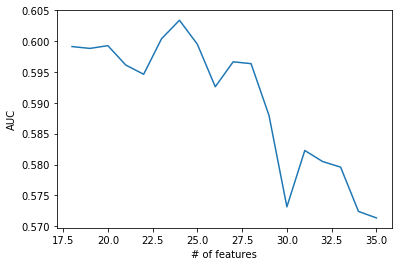

CPU times: user 7min 48s, sys: 34.9 s, total: 8min 23s
Wall time: 6min 5s


In [7]:
%%time

X = opioids_engage30.drop(columns=['engage30'])
y = opioids_engage30['engage30']
feature_dict_opioids_engage30 = bidirectional_feature_importance(X, y)

In [16]:
feature_dict_opioids_engage30[25]

['female_cd',
 'SFSg_0_cd',
 'loc_cd_3',
 'loc_cd_1',
 'prsatx_cd',
 'epsg_0_cd',
 'und15_cd',
 'loc_cd_9',
 'homeless_0_cd',
 'gvsg_cd',
 'loc_cd_2',
 'dldiag_cd',
 'S6_cd',
 'ncar_cd',
 'suicprbs_0_cd',
 'gcsg_0_cd',
 'dssg_0_cd',
 'S9y10_cd']

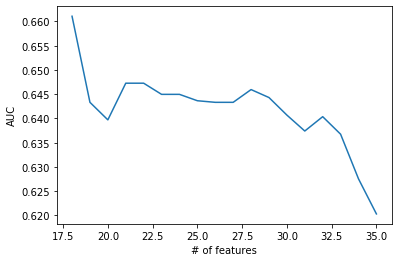

CPU times: user 7min 1s, sys: 27.2 s, total: 7min 28s
Wall time: 4min 54s


In [8]:
%%time

X = opioids_init.drop(columns=['init'])
y = opioids_init['init']
feature_dict_opioids_init = bidirectional_feature_importance(X, y)

In [13]:
feature_dict_opioids_init[18]

['adhdg_0_cd',
 'ncar_cd',
 'und15_cd',
 'Raceg4_cd_1',
 'Raceg4_cd_3',
 'S6_cd',
 'loc_cd_1',
 'Raceg4_cd_2',
 'TMIg_0_cd',
 'srprobg_cd',
 'TRIg_0_cd',
 'dldiag_cd',
 'unemplmt_cd',
 'lrig_0_cd',
 'CWSg_0_cd',
 'dssg_0_cd',
 'tsd_0_cd',
 'SFSg_0_cd']

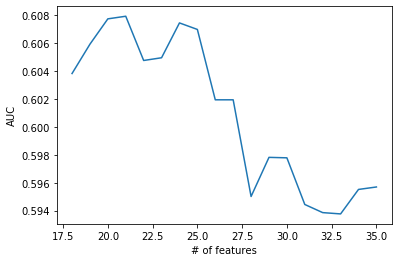

CPU times: user 7min 45s, sys: 32.8 s, total: 8min 18s
Wall time: 4min 28s


In [9]:
%%time

X = stimulants_engage30.drop(columns=['engage30'])
y = stimulants_engage30['engage30']
feature_dict_stimulants_engage30 = bidirectional_feature_importance(X, y)

In [14]:
feature_dict_stimulants_engage30[22]

['cjsig_0_cd',
 'loc_cd_9',
 'loc_cd_6',
 'gcsg_0_cd',
 'TMIg_0_cd',
 'S9y10_cd',
 'loc_cd_2',
 'Raceg4_cd_1',
 'ncar_cd',
 'lrig_0_cd',
 'epsg_0_cd',
 'loc_cd_3',
 'female_cd',
 'dssg_0_cd',
 'CWSg_0_cd',
 'und15_cd',
 'srprobg_cd',
 'srig_0_cd']

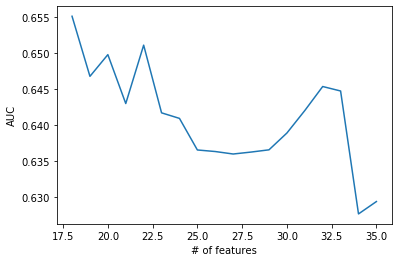

CPU times: user 6min 53s, sys: 27.9 s, total: 7min 21s
Wall time: 3min 57s


In [10]:
%%time

X = stimulants_init.drop(columns=['init'])
y = stimulants_init['init']
feature_dict_stimulants_init = bidirectional_feature_importance(X, y)

In [15]:
feature_dict_stimulants_init[18]

['epsg_0_cd',
 'loc_cd_1',
 'loc_cd_3',
 'unemplmt_cd',
 'loc_cd_2',
 'homeless_0_cd',
 'TRIg_0_cd',
 'srig_0_cd',
 'suicprbs_0_cd',
 'loc_cd_9',
 'Raceg4_cd_4',
 'nonwhite_cd',
 'CWSg_0_cd',
 'female_cd',
 'Raceg4_cd_3',
 'gcsg_0_cd',
 'SESg_0_cd',
 'cdsg_0_cd']

In [11]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 19 minutes 27 seconds ---
